<a href="https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/stable_baselines_multiprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiprocessing of environments with Stable Baselines

## Install Dependencies and Stable Baselines Using Pip

In [1]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


## Import Matplotlib for plotting, Gym for the environment and 
SubprocVecEnv enables several instances of the same environment to be run on parallel processse. This provides two benefits:
* Agent experience can be collected more quickly
* The experience will contain a more diverse range of states

In [0]:
# Filter tensorflow version warnings
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)


import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2

## Define an Evaluate function

In [0]:

def evaluate(model, env, num_episodes=100):
    # This function will only work for a single Environment
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    # print("Mean reward over {} episodes {}".format(
    #     mean_episode_reward, num_episodes))
    return mean_episode_reward

## Define an environment function

The multiprocessing implementation requires a function that can be called inside the process to instantiate a gym env

In [0]:

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

## Define a few constants (feel free to try out other environments and algorithms)
We will be using the Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)



In [0]:
env_id = 'CartPole-v1'
PROCESSES_TO_TEST = [1, 2, 4, 8, 16] 
NUM_EXPERIMENTS = 3 # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
EVAL_EPS = 20
ALGO = PPO2

# We will create one environment to evaluate the agent on
eval_env = DummyVecEnv([lambda: gym.make(env_id)])

## Iterate through the different numbers of processes
For each processes, several experiements are run per process
This may take a couple of minutes.

In [6]:

reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print('Running for n_procs = {}'.format(n_procs))
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='spawn')

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiements due to h
        train_env.reset()
        model = ALGO(MlpPolicy, train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time()-start)
        mean_reward = evaluate(model, eval_env, num_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


## Plot the results

Text(0, 0.5, 'Training steps per second')

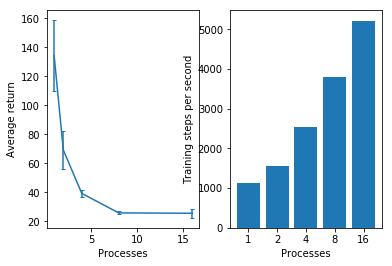

In [7]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2)
plt.xlabel('Processes')
plt.ylabel('Average return')
plt.subplot(1,2,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

## The trade-off
There is clearly a trade-off between sample efficiency, diverse experience and wall clock time. Lets try getting the best performance in a fixed amount of time, say 10 seconds per experiment

In [8]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print('Running for n_procs = {} for steps = {}'.format(n_procs, train_steps))
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method='spawn')

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiements due to h
        train_env.reset()
        model = ALGO(MlpPolicy, train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time()-start)
        mean_reward = evaluate(model, eval_env, num_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))


Running for n_procs = 1 for steps = 11237
Running for n_procs = 2 for steps = 15456
Running for n_procs = 4 for steps = 25452
Running for n_procs = 8 for steps = 38064
Running for n_procs = 16 for steps = 52189


## Plot the results

Text(0, 0.5, 'Training steps per second')

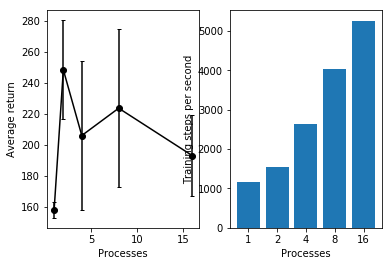

In [9]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plt.figure()
plt.subplot(1,2,1)
plt.errorbar(PROCESSES_TO_TEST, reward_averages, yerr=reward_std, capsize=2, c='k', marker='o')
plt.xlabel('Processes')
plt.ylabel('Average return')
plt.subplot(1,2,2)
plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
plt.xticks(range(len(PROCESSES_TO_TEST)),PROCESSES_TO_TEST)
plt.xlabel('Processes')
plt.ylabel('Training steps per second')

## Conclusions
This notebook has highlighted some of the pros and cons of multiprocessing. It is worth mentioning that colab notebooks only provide two CPU cores per process, so we do not see a linear scaling of the FPS of the environments. State of the art Deep RL research has scaled parallel processing to tens of thousands of CPU cores, [OpenAI RAPID](https://openai.com/blog/how-to-train-your-openai-five/) [IMPALA](https://arxiv.org/abs/1802.01561).

Do you think this direction of research is transferable to real world robots / intelligent agents?

Things to try:
* Another algorithm / environment.
* Increase the number of experiments.
* Train for more iterations.
